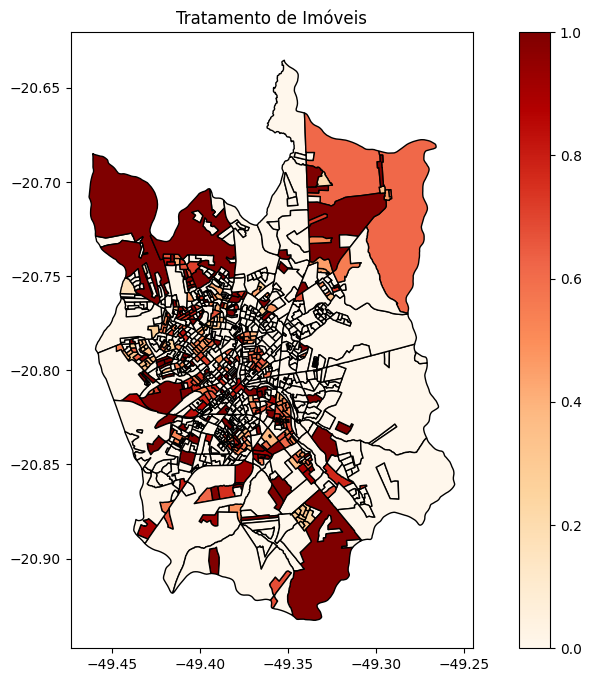

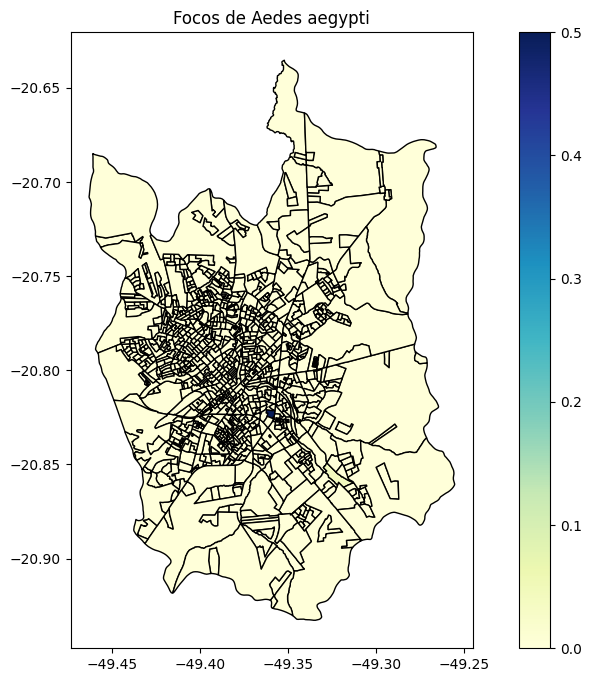

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt

# Passo 1: Carregar os dados
df = pd.read_csv("C:/Users/celso/Desktop/WIKI_DENGUE/lab-soft-wiki/encyclopedia/data_analytics/Sisaweb/dados_merged.csv")

# Passo 2: Converter 'geometry' para objetos geométricos
df['geometry'] = df['geometry'].apply(wkt.loads)

# Passo 3: Criar um GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Passo 4: Definir o sistema de referência de coordenadas (CRS)
gdf.crs = "EPSG:4326"

# Passo 5: Calcular a métrica de tratamento de imóveis
gdf['tratamento_imoveis'] = gdf.apply(
    lambda row: row['trabalhados'] / (row['trabalhados'] + row['nao_trabalhados'])
    if (row['trabalhados'] + row['nao_trabalhados']) > 0 else 0,
    axis=1
)

# Passo 6: Calcular a métrica de focos de Aedes aegypti
gdf['focos_aedes'] = gdf.apply(
    lambda row: row['im_aegypti'] / row['trabalhados']
    if row['trabalhados'] > 0 else 0,
    axis=1
)

# Passo 7: Criar o mapa de calor para tratamento de imóveis
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf.plot(column='tratamento_imoveis', ax=ax, legend=True, cmap='OrRd', edgecolor='black')
ax.set_title('Tratamento de Imóveis')
plt.show()

# Passo 8: Criar o mapa de calor para focos de Aedes aegypti
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf.plot(column='focos_aedes', ax=ax, legend=True, cmap='YlGnBu', edgecolor='black')
ax.set_title('Focos de Aedes aegypti')
plt.show()


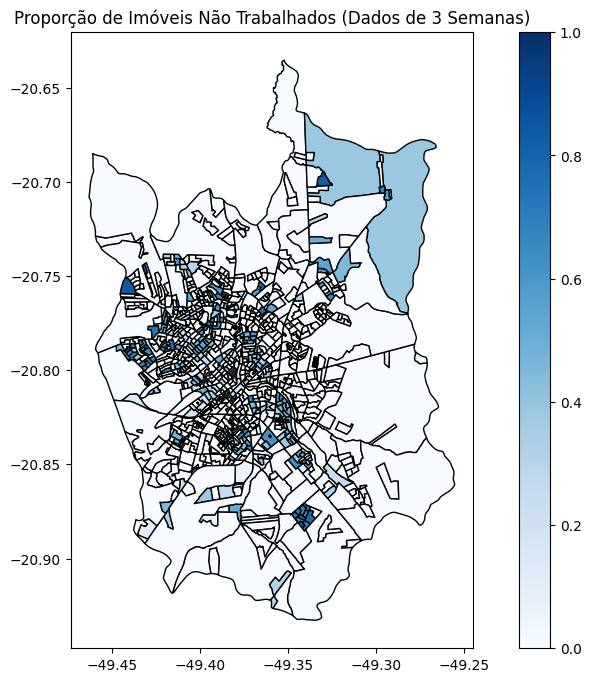

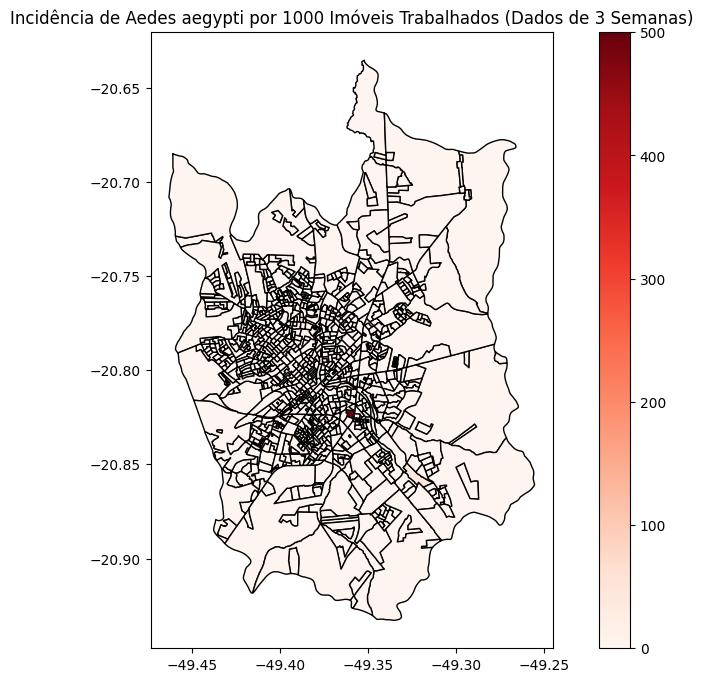

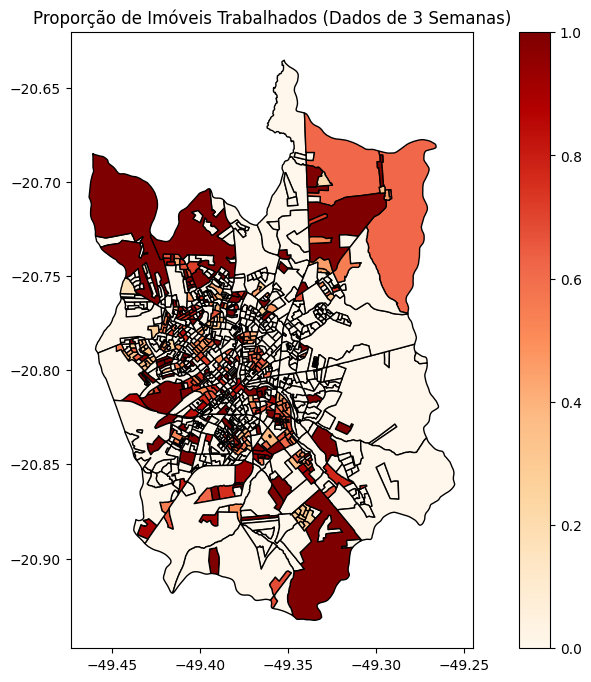

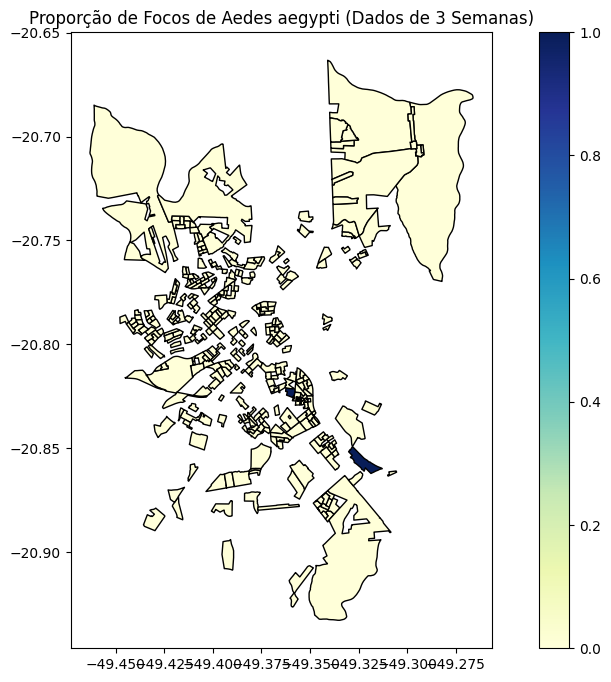

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt

# Passo 1: Carregar os dados
df = pd.read_csv('dados_merged.csv')

# Passo 2: Converter 'geometry' para objetos geométricos
df['geometry'] = df['geometry'].apply(wkt.loads)

# Passo 3: Criar um GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Passo 4: Definir o sistema de referência de coordenadas (CRS)
gdf.crs = "EPSG:4326"

# Passo 5: Calcular a métrica de tratamento de imóveis (imóveis trabalhados)
gdf['tratamento_imoveis'] = gdf.apply(
    lambda row: row['trabalhados'] / (row['trabalhados'] + row['nao_trabalhados'])
    if (row['trabalhados'] + row['nao_trabalhados']) > 0 else 0,
    axis=1
)

# Passo 6: Calcular a métrica de imóveis não trabalhados
gdf['nao_trabalhados_ratio'] = gdf.apply(
    lambda row: row['nao_trabalhados'] / (row['trabalhados'] + row['nao_trabalhados'])
    if (row['trabalhados'] + row['nao_trabalhados']) > 0 else 0,
    axis=1
)

# Passo 7: Calcular a incidência de Aedes aegypti por 1000 imóveis trabalhados
gdf['incidencia_aedes'] = gdf.apply(
    lambda row: (row['im_aegypti'] / row['trabalhados']) * 1000
    if row['trabalhados'] > 0 else 0,
    axis=1
)

# Passo 8: Criar o mapa de calor para imóveis não trabalhados
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf.plot(column='nao_trabalhados_ratio', ax=ax, legend=True, cmap='Blues', edgecolor='black')
ax.set_title('Proporção de Imóveis Não Trabalhados (Dados de 3 Semanas)')
plt.show()

# Passo 9: Criar o mapa de calor para incidência de Aedes aegypti
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf.plot(column='incidencia_aedes', ax=ax, legend=True, cmap='Reds', edgecolor='black')
ax.set_title('Incidência de Aedes aegypti por 1000 Imóveis Trabalhados (Dados de 3 Semanas)')
plt.show()

# Passo 10: Atualizar o mapa de tratamento de imóveis com o título atualizado
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf.plot(column='tratamento_imoveis', ax=ax, legend=True, cmap='OrRd', edgecolor='black')
ax.set_title('Proporção de Imóveis Trabalhados (Dados de 3 Semanas)')
plt.show()


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import plotly.express as px
import shapely.geometry

# ... (restante do código permanece o mesmo)

# Função para criar mapas coropléticos interativos
def plot_choropleth_map(gdf, column, title, color_scale):
    # Reprojetar para um CRS projetado para calcular centroides corretamente
    gdf_projected = gdf.to_crs(epsg=3857)
    centroid = gdf_projected.geometry.centroid
    mean_x = centroid.x.mean()
    mean_y = centroid.y.mean()
    # Converter o ponto central de volta para EPSG:4326
    center_point = gpd.GeoSeries([shapely.geometry.Point(mean_x, mean_y)], crs=3857).to_crs(epsg=4326)
    center_lat = center_point.geometry.y.values[0]
    center_lon = center_point.geometry.x.values[0]
    
    fig = px.choropleth_mapbox(
        gdf,
        geojson=gdf_json,
        locations='id',
        color=column,
        color_continuous_scale=color_scale,
        mapbox_style="carto-positron",
        zoom=10,
        center={"lat": center_lat, "lon": center_lon},
        opacity=0.5,
        labels={column: title},
        hover_data={
            'tratamento_imoveis': ':.2f',
            'incidencia_aedes': ':.2f',
            'nao_trabalhados_ratio': ':.2f'
        }
    )
    fig.update_layout(
        title_text=title + ' (Dados de 3 Semanas)',
        margin={"r": 0, "t": 30, "l": 0, "b": 0}
    )
    # Salvar a figura como arquivo HTML
    output_html = f"{title.replace(' ', '_').lower()}.html"
    fig.write_html(output_html, include_plotlyjs='cdn')
    print(f"Mapa salvo como {output_html}")

# Passo 8: Criar o mapa de calor para imóveis não trabalhados
plot_choropleth_map(
    gdf,
    'nao_trabalhados_ratio',
    'Proporção de Imóveis Não Trabalhados',
    'Blues'
)

# Passo 9: Criar o mapa de calor para incidência de Aedes aegypti
plot_choropleth_map(
    gdf,
    'incidencia_aedes',
    'Incidência de Aedes aegypti por 1000 Imóveis Trabalhados',
    'Reds'
)

# Passo 10: Criar o mapa de calor para imóveis trabalhados
plot_choropleth_map(
    gdf,
    'tratamento_imoveis',
    'Proporção de Imóveis Trabalhados',
    'OrRd'
)


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed